# 200 Epochs, GCT attention

## Custom Parameters
Here you can change some of the main parameters of the model

In [1]:
width = 256
height = 256

epochs = 100

batch_size = 8
learning_rate = 0.001

new_aug_epoch_distance = 5 #how many epochs between new augmentations
number_of_augmentations = 3

show_images = True

In [2]:
OPENSLIDE_PATH = r'D:\Estudos\IC\Libraries\openslide-bin-4.0.0.3-windows-x64\openslide-bin-4.0.0.3-windows-x64\bin'

import os
if hasattr(os, 'add_dll_directory'):
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

### Imports

In [3]:
import sys
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from torchvision import ops
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import albumentations as A
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights


sys.path.append(r'D:\Estudos\IC\CNN\CNN\Model')
from TrainingDataArrangement import arrange_data
import CustomDataset
from UNetModel import UNet
from DaliDataAug import load_pil_image, data_augmentation


#defining device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


Using cuda device


### Setting the seed

In [4]:
def set_seed(seed):  
    random.seed(seed) #setting for albumentations
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(727)

### Getting the dataset

C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydantic\main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Target path already exists. Please delete it first if you want to re-arrange the data, exiting...
Target path already exists. Please delete it first if you want to re-arrange the data, exiting...
Target path already exists. Please delete it first if you want to re-arrange the data, exiting...
Showing images: True
Getting the images
Converting images to tensors


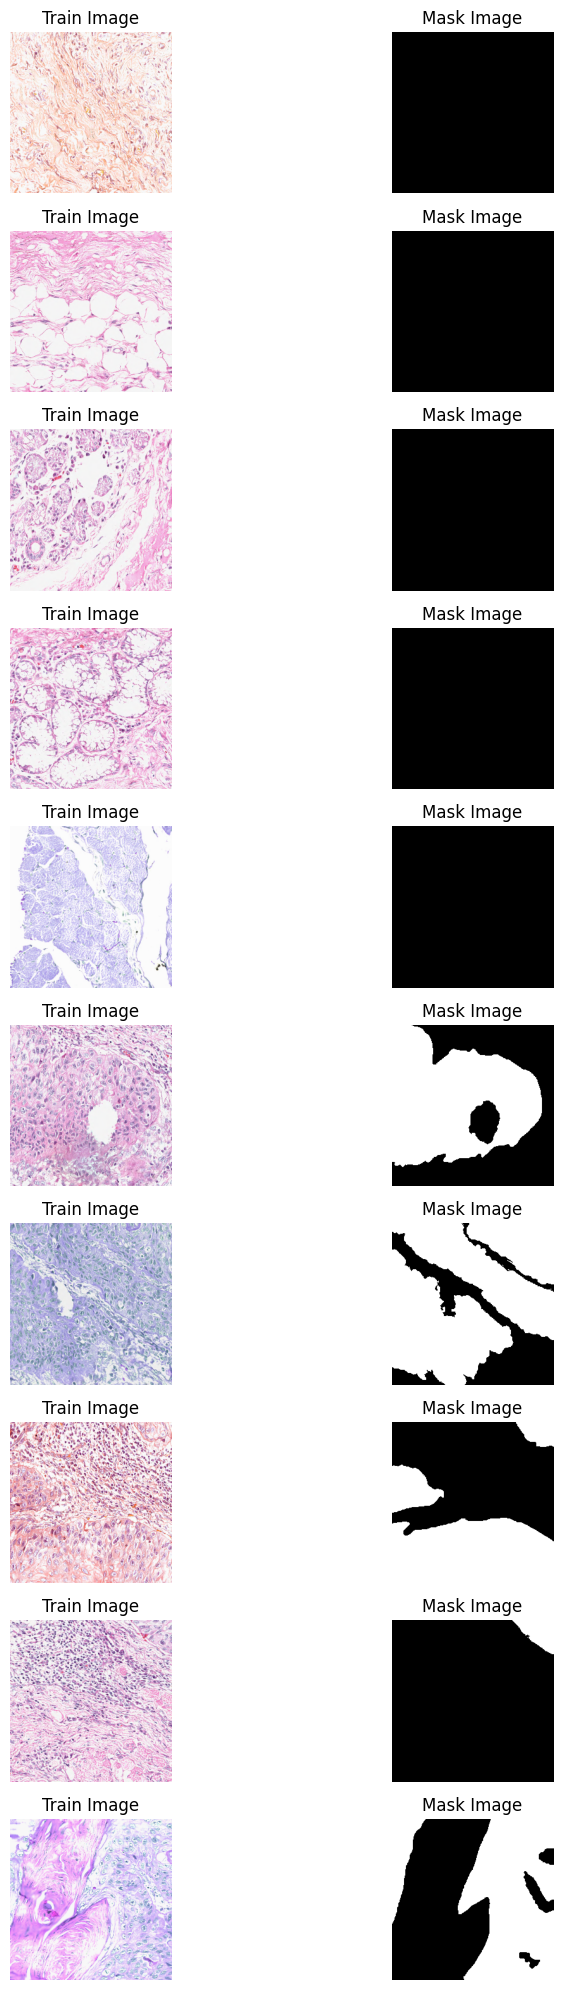

In [5]:
#getting path references
testing_folders = [
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009009\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009010x1000902\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009011\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009014\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009016x1000903\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009023\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009009\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009010x1000902\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009011\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009014\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009016x1000903\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\testing\tumor\patch\640x640\1009023\02-non_roi"
]

training_folders = [
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009009\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009010x1000902\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009011\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009014\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009016x1000903\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009023\01-roi",
    # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009009\02-non_roi",
    # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009010x1000902\02-non_roi",
    # # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009011\02-non_roi",
    # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009014\02-non_roi",
    # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009016x1000903\02-non_roi",
    # r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009023\02-non_roi"
]
resnet_training_folders = [
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009009\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009010x1000902\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009011\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009014\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009016x1000903\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009023\01-roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009009\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009010x1000902\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009011\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009014\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009016x1000903\02-non_roi",
    r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\training\tumor\patch\640x640\1009023\02-non_roi"
]


updated_training_folders = []
updated_testing_folders = []
updated_resnet_training_folders = []

for training_folder, testing_folder in zip(training_folders, testing_folders):
    original_training_folder = training_folder + "\\01-original"
    mask_training_folder = training_folder + "\\02-mask"
    updated_training_folders.extend([original_training_folder, mask_training_folder])

    original_testing_folder = testing_folder + "\\01-original"
    mask_testing_folder = testing_folder + "\\02-mask"
    updated_testing_folders.extend([original_testing_folder, mask_testing_folder])

for training_folder in resnet_training_folders:
    original_training_folder = training_folder + "\\01-original"
    mask_training_folder = training_folder + "\\02-mask"
    updated_resnet_training_folders.extend([original_training_folder, mask_training_folder])

training_path = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\training"
test_path = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing"
resnet_training_path = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\resnet_training"

arrange_data(test_path,updated_testing_folders)
arrange_data(training_path,updated_training_folders)
arrange_data(resnet_training_path,updated_resnet_training_folders)

#data augmentation
augmentation_transform = A.Compose([
    #A.ToPIL(),
    A.Resize(width = width, height = height, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.25),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    A.Transpose(p=0.25),
    #A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    # A.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3), interpolation=1, border_mode=4, p=0.3),
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.3),
    # A.OpticalDistortion(distort_limit=(-0.05, 0.05), shift_limit=(-0.05, 0.05), interpolation=1, border_mode=4, p=0.3),
    # A.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, p=0.3),
    # A.PiecewiseAffine (scale=(0.03, 0.05), nb_rows=4, nb_cols=4, interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode='constant', absolute_scale=False, keypoints_threshold=0.01, p=0.1),
    # A.ShiftScaleRotate (shift_limit=(-0.0625, 0.0625), scale_limit=(-0.1, 0.1), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=0, mask_value=0, rotate_method='largest_box', p=0.15),
    ToTensorV2()  # loading image to tensor and normalization
])
test_transform = A.Compose([
    #A.ToPIL(),
    A.Resize(width = width, height = height, p=1.0),
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.25),
    #A.RandomRotate90(p=0.5),
    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #A.Transpose(p=0.5),
    #A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    ToTensorV2()  # loading image to tensor and normalization
])

print("Showing images:", show_images)

print("Getting the images")
training_dataset = CustomDataset.CustomImageDataset(training_path + "\\images", training_path + "\\masks", transform=augmentation_transform)
test_dataset = CustomDataset.CustomImageDataset(test_path + "\\images", test_path + "\\masks", transform=test_transform)

resnet_dataset = CustomDataset.CustomImageDataset(resnet_training_path + "\\images", resnet_training_path + "\\masks", transform=augmentation_transform)
resnet_dataloader = DataLoader(resnet_dataset, batch_size=batch_size, shuffle=True)

print("Converting images to tensors")
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)
if(show_images):
    num_images_to_display = 10
    fig, axs = plt.subplots(num_images_to_display, 2, figsize=(10, 20))
    for i in range(num_images_to_display):
        train_image, mask_image = training_dataset[i]
        train_image = train_image.permute(1, 2, 0).numpy()

        axs[i, 0].imshow(train_image)
        axs[i, 0].set_title('Train Image')
        axs[i, 0].axis('off')

        mask_image = mask_image.squeeze(0).numpy()
        axs[i, 1].imshow(mask_image, cmap='gray')
        axs[i, 1].set_title('Mask Image')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


### Dir Checker

In [6]:

def dir_checker_and_restarter(images_dir):
    os.makedirs(images_dir, exist_ok=True)
    for filename in os.listdir(images_dir): #deleting all previous images files
        file_path = os.path.join(images_dir, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

def save_image(image, path):
    image.save(path)

def recreate_data_loader(number_of_augmentations = 5):
    input_dir_train = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\training"
    output_dir_train = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\training\transformed"

    input_dir_test = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing"
    output_dir_test = r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\transformed"

    main_dirs = [output_dir_train, output_dir_test]

    for dir in main_dirs:
        if not os.path.exists(dir):
            os.makedirs(dir + "\images")
            os.makedirs(dir + "\masks")
        else:
            dir_checker_and_restarter(dir)

    augmentation = ["horizontal_flip", "vertical_flip", "rotation", "transpose"]

    img_input_size = (640, 640)
    img_output_size = (width, height)

    input_output_mapping = {
        "training": output_dir_train,
        "testing": output_dir_test
    }

    dirs = [input_dir_train, input_dir_test]
    for i in range(number_of_augmentations):
        for dir in dirs:
            img_path_appended = os.path.join(dir, "images")
            mask_path_appended = os.path.join(dir, "masks")

            image_files = [f for f in os.listdir(img_path_appended) if f.endswith(('.jpg', '.png', '.jpeg', 'tif'))]
            mask_files = [f for f in os.listdir(mask_path_appended) if f.endswith(('.jpg', '.png', '.jpeg', 'tif'))]

            for img_name, mask_name in zip(image_files, mask_files):
                img_path = os.path.join(img_path_appended, img_name)
                mask_path = os.path.join(mask_path_appended, mask_name)

                input_image = load_pil_image(img_path, False)
                mask = load_pil_image(mask_path, False)

                target_image = None
                GAN_model = None

                augmented_img, augmented_mask, used_augmentations = data_augmentation(input_image, target_image, mask, img_input_size, img_output_size, augmentation, GAN_model)

                for key in input_output_mapping:
                    if key in dir:
                        output_dir = input_output_mapping[key]
                        break
                    
                output_img_path = os.path.join(output_dir, f"images\\aug{i}_{img_name}")
                output_mask_path = os.path.join(output_dir, f"masks\\aug{i}_{mask_name}")
                save_image(TF.to_pil_image(augmented_img), output_img_path)
                save_image(TF.to_pil_image(augmented_mask), output_mask_path)
    print(f"Finished loading {number_of_augmentations} new augmentations in the whole dataset")
                



    training_dataset = CustomDataset.CustomImageDataset(output_dir_train + "\\images", output_dir_train + "\\masks", transform=test_transform)
    test_dataset = CustomDataset.CustomImageDataset(output_dir_test + "\\images", output_dir_test + "\\masks", transform=test_transform)
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader
train_dataloader, test_dataloader = recreate_data_loader(number_of_augmentations)
    

Finished loading 3 new augmentations in the whole dataset


### Setting GradCAM

In [7]:
gradcam_width = width
gradcam_height = height

def save_and_display_gradcam(img_path, heatmap, alpha=0.6):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (gradcam_width, gradcam_height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    mask_path = img_path.replace(r"\testing\images", r"\testing\masks")
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (gradcam_width, gradcam_height))

    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.title("Original Mask With Image")
    plt.axis('off')
    plt.show()

def make_gradcam_heatmap(img_tensor, model, target_layer):
    model.eval()
    
    features = None
    gradients = None
    
    def forward_hook(module, input, output):
        nonlocal features
        features = output
    
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_full_backward_hook(backward_hook)
    
    with amp.autocast():
        preds = model(img_tensor)
        pred_class = preds.argmax(dim=1)
    
    model.zero_grad()
    class_score = preds[:, pred_class].squeeze().sum()
    class_score.backward(retain_graph=True)
    
    handle_forward.remove()
    handle_backward.remove()
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = features.mean(dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
    epsilon = 1e-8
    heatmap_max = np.max(heatmap)
    heatmap = heatmap / (heatmap_max + epsilon)
    
    del features, gradients
    torch.cuda.empty_cache()
    
    return heatmap

def make_prediction_and_visualize(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (gradcam_width, gradcam_height))
        img_tensor = torch.tensor(img / 255.0).permute(2, 0, 1).unsqueeze(0).float()

        target_layer = model.upconv2

        heatmap = make_gradcam_heatmap(img_tensor.to(device), model, target_layer)

        save_and_display_gradcam(img_path, heatmap)

def generate_heatmap(img_path): 
    img = cv2.imread(img_path)
    img = cv2.resize(img, (gradcam_width, gradcam_height))
    img_tensor = torch.tensor(img / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    target_layer = model.upconv2
    return make_gradcam_heatmap(img_tensor.to(device), model, target_layer)

def generate_heatmap_with_tensor(img): 
    target_layer = model.upconv2
    return make_gradcam_heatmap(img.unsqueeze(0), model, target_layer)





# image_paths = [
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r27c5.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r27c10.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r28c12.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r31c0.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r31c1.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r35c4.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r35c8.png",
#     r"D:\Estudos\IC\DataSets\H&E-stained oral squamous cell carcinoma histological images dataset\H&E-stained oral squamous cell carcinoma histological images dataset\appended_folder\testing\images\1009009_r35c10.png",
# ]

# make_prediction_and_visualize(image_paths)




### Setting ResNet

In [8]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM
from pytorch_grad_cam import EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image


def generate_ResNet_CAM(model, image, index, cam_layer, cam_type = "gradcam"):
    target_layers = cam_layer
    
    input_tensor = image

    targets = [ClassifierOutputTarget(1)]

    def denormalize(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(3, 1, 1)

        image = image * std + mean
        return image

    def to_numpy_uint8(image):
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
        return image

    image_to_show = denormalize(image[index])
    image_to_show = to_numpy_uint8(image_to_show)
    image_to_show = image_to_show / 255

    match cam_type.lower():
            case "gradcam":
                with GradCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "hirescam":
                with HiResCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "gradcamelementwise":
                with GradCAMElementWise(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "gradcam++":
                with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "xgradcam":
                with XGradCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "ablationcam":
                with AblationCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "scorecam":
                with ScoreCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "eigencam":
                with EigenCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "eigengradcam":
                with EigenGradCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case "layercam":
                with LayerCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            case _:
                raise ValueError(f"CAM type '{cam_type}' invalid")
    
    grayscale_cam = grayscale_cam[0, :]
    return show_cam_on_image(image_to_show, grayscale_cam, use_rgb=True)

In [9]:



model_resnet = resnet50(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)
model_resnet = model_resnet.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4)

resnet_epochs = epochs #// 2

train_losses = []
train_accuracies = []

for epoch in range(resnet_epochs):
    model_resnet.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, masks in tqdm(resnet_dataloader, desc=f'Epoch {epoch + 1}/{resnet_epochs}', leave=False):
        images, masks = images.to(device), masks.to(device)

        # Create labels: 1 if any mask > 0, else 0
        labels = torch.tensor([1 if torch.any(mask > 0) else 0 for mask in masks], dtype=torch.long, device=device)
        
        optimizer.zero_grad()
        outputs = model_resnet(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Accuracy
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(resnet_dataloader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{resnet_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')



C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2 - Loss: 0.4086 - Accuracy: 0.8071


Epoch 2/2 - Loss: 0.3259 - Accuracy: 0.8721


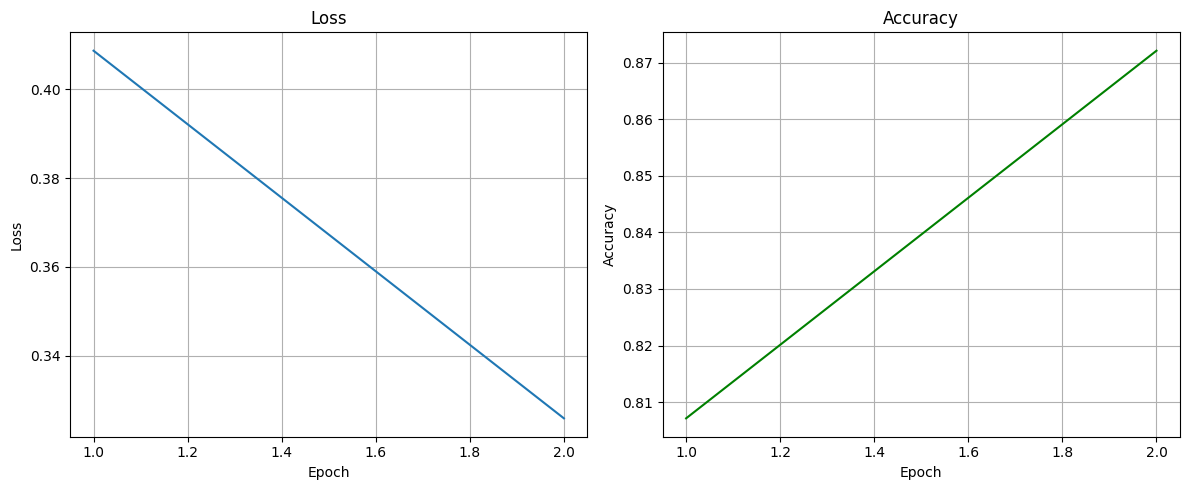

  0%|          | 0/155 [00:00<?, ?it/s]


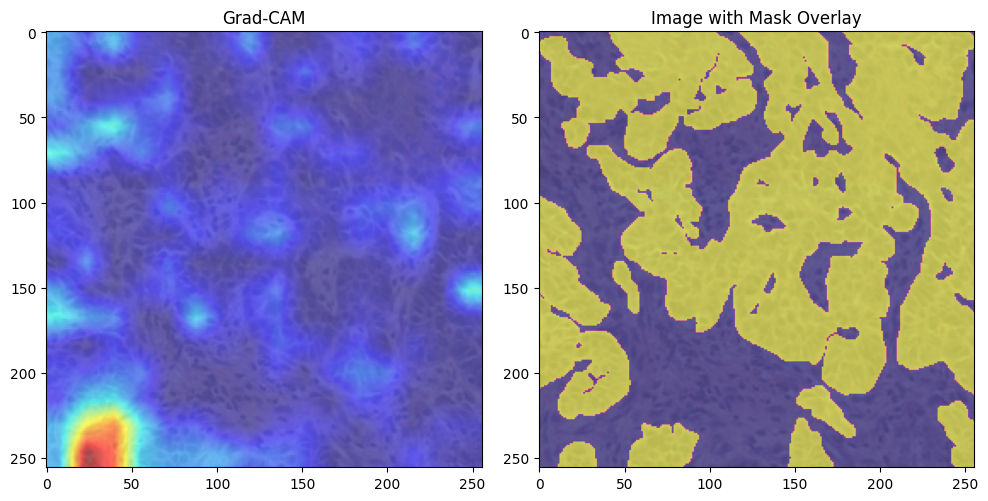

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, resnet_epochs + 1), train_losses, label='Training Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, resnet_epochs + 1), train_accuracies, color='green', label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


image = []
mask = []

model_resnet.eval()
with torch.no_grad():
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        if torch.any(masks > 0):
            test_image_resnet = images[0].detach()
            image = test_image_resnet
            mask = masks[0].detach()
            break

first_image_batch = test_image_resnet.unsqueeze(0)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
cam_image = generate_ResNet_CAM(model_resnet, first_image_batch, 0, [model_resnet.layer3[-1]], "xgradcam")
plt.imshow(cam_image)
plt.title('Grad-CAM')

plt.subplot(1, 2, 2)
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

image_to_show = denormalize(image)
plt.imshow(image_to_show)
plt.imshow(mask.cpu().numpy()[0], alpha=0.5, cmap='plasma')
plt.title('Image with Mask Overlay')

plt.tight_layout()
plt.show()

### Training

Epoch 1 Loss: 0.4734, Accuracy: 77.39%


Validation Loss: 0.4651, Validation Accuracy: 79.82%



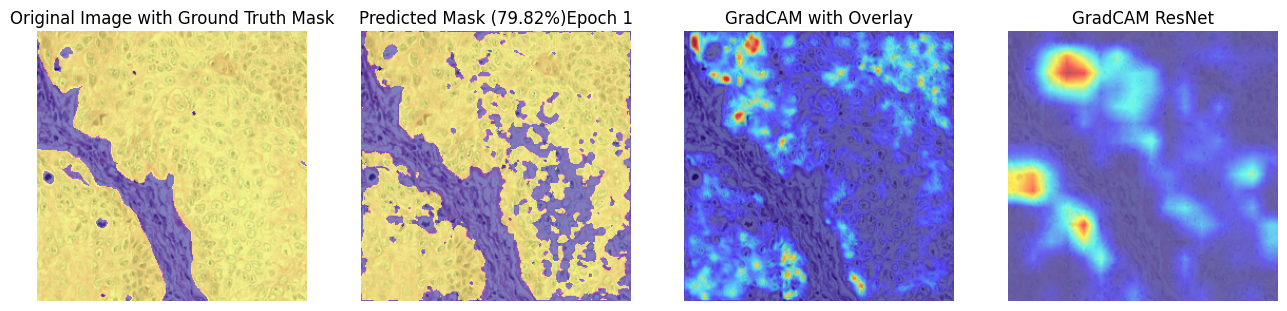

Epoch 2 Loss: 0.4235, Accuracy: 80.25%


Validation Loss: 0.4279, Validation Accuracy: 80.49%



In [11]:
channels = 3
classes = 1
model = UNet(channels, classes, use_attention=True, attention_type="GCT_Attention")
input_data = torch.randn(1, channels, width, height)
output = model(input_data)
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

num_epochs = epochs

training_accuracies = []
training_losses = []
val_losses = []
val_accuracies = []

images_dir = "epoch_images"
dir_checker_and_restarter(images_dir)
for images, masks in test_dataloader:
    images, masks = images.to(device), masks.to(device)
    if torch.any(masks > 0):
        first_image_in_dataset = images[0].detach()
        break
first_image_batch = first_image_in_dataset.unsqueeze(0)
resnet_img = generate_ResNet_CAM(model_resnet, first_image_batch, 0, [model_resnet.layer3[-1]], "xgradcam")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    

    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = F.binary_cross_entropy(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #thresholding the prediction values
        _, predicted = torch.max(outputs, 1)
        binary_predictions = (outputs > 0.5).float()
        
        #calculating the correct pixels
        correct_predictions += (binary_predictions == masks).sum().item()

        total_samples += masks.numel()
    
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples

    training_accuracies.append(epoch_accuracy)
    training_losses.append(epoch_loss)

    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")

    #validation
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0   
    with torch.no_grad():
        for val_images, val_masks in tqdm(test_dataloader, desc='Validation', leave=False):
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)

            val_loss += F.binary_cross_entropy(val_outputs, val_masks).item()

            val_binary_predictions = (val_outputs > 0.5).float()

            val_correct_predictions += (val_binary_predictions == val_masks).sum().item()

            val_total_samples += val_masks.numel()

    val_epoch_loss = val_loss / len(test_dataloader)
    val_epoch_accuracy = val_correct_predictions / val_total_samples

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy * 100:.2f}%\n")
    print("============================================")
            

    if(show_images):
        heatmap = generate_heatmap_with_tensor(first_image_in_dataset.to(device).half())#making heatmap only of the first image of the batch
        with torch.no_grad():
            for images, masks in test_dataloader:
                images, masks = images.to(device), masks.to(device)

                if torch.any(masks > 0):
                    
                    outputs = model(images)
                    probs = outputs
                    images_np = images.cpu().numpy()
                    masks_np = masks.cpu().numpy()
                    probs_np = probs.cpu().numpy()
                    threshold = 0.5
                    preds_np = (probs_np > threshold).astype(np.uint8)
                    preds_np_squeezed = np.squeeze(preds_np, axis=1) 
                    plt.figure(figsize=(16, 8))
                    plt.subplot(1, 4, 1)
                    plt.imshow(images_np[0].transpose((1, 2, 0)))
                    plt.imshow(masks_np[0, 0], alpha=0.5, cmap='plasma')
                    plt.title("Original Image with Ground Truth Mask")
                    plt.axis('off')
                    plt.subplot(1, 4, 2)
                    plt.imshow(images_np[0].transpose((1, 2, 0)))
                    plt.imshow(preds_np_squeezed[0], alpha=0.5, cmap='plasma')
                    plt.title("Predicted Mask" + f" ({val_epoch_accuracy * 100:.2f}%)" + f"Epoch {epoch + 1}")
                    plt.axis('off')
                    
                    #gradcam heatmap
                    img = first_image_in_dataset.cpu().detach().permute(1, 2, 0).numpy()
                    img = (img - img.min()) / (img.max() - img.min()) #normalizing
                    img = np.uint8(255 * img)

                    heatmap = np.uint8(255 * heatmap)
                    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
                    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

                    superimposed_img = cv2.addWeighted(heatmap, 0.6, img, 1 - 0.6, 0)

                    plt.subplot(1, 4, 3)
                    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
                    plt.title('GradCAM with Overlay')
                    plt.axis('off')

                    plt.subplot(1, 4, 4)
                    plt.imshow(resnet_img)
                    plt.title('GradCAM ResNet')
                    plt.axis('off')

                    #saving the figs for the gif
                    plt.savefig(os.path.join(images_dir, f'epoch_{epoch + 1}.png'))
                    if epoch % 5 == 0: plt.show()
                    plt.close()
                    break
    if epoch % new_aug_epoch_distance == 0 and epoch != 0: #dynamic data loader changing to improve loss
        train_dataloader, test_dataloader = recreate_data_loader(number_of_augmentations)

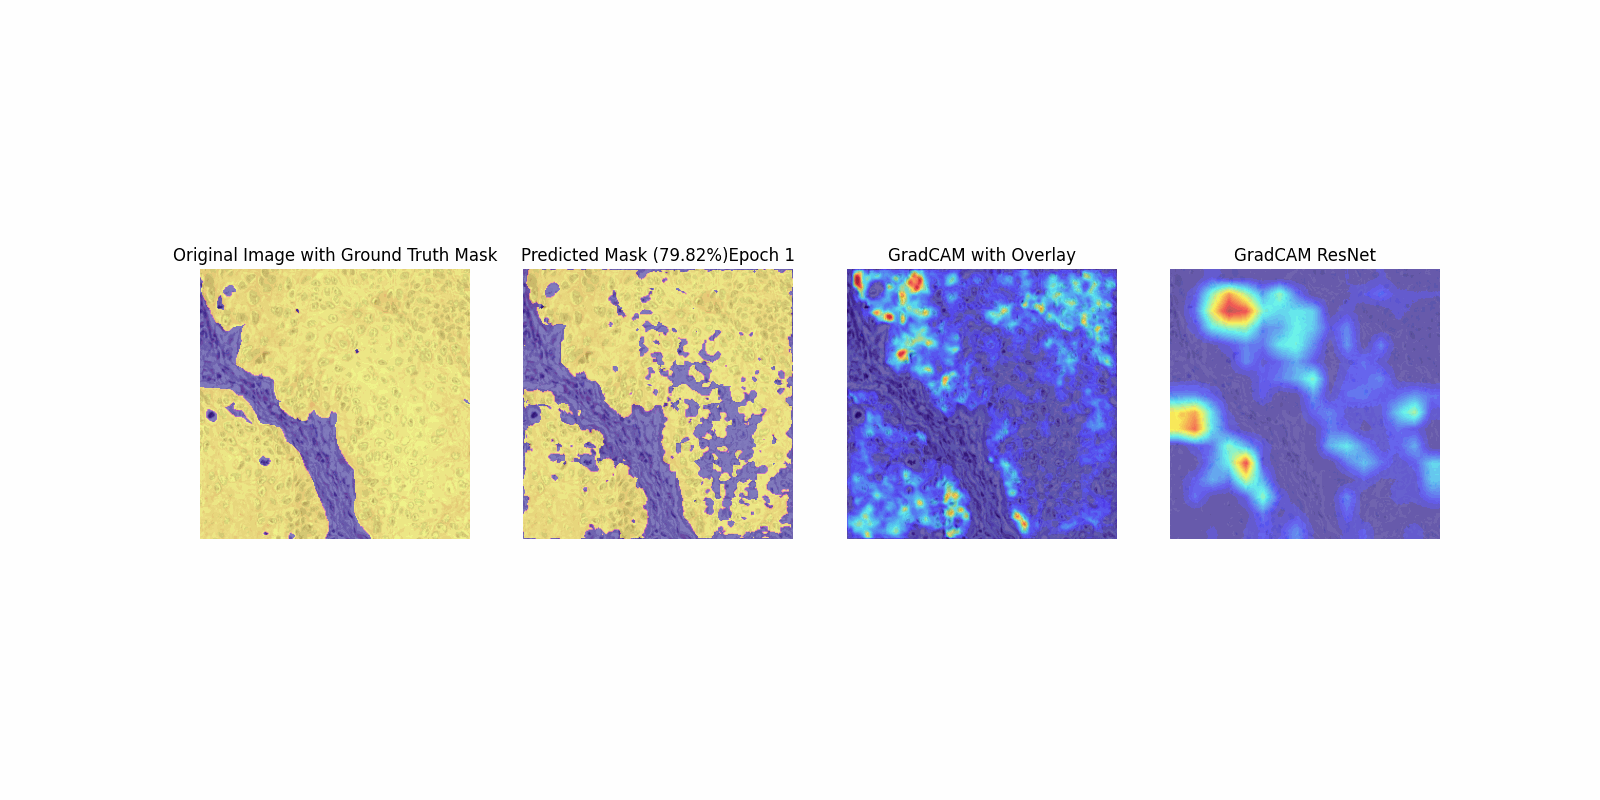

In [12]:
import imageio


images = []
for epoch in range(1, num_epochs + 1):
    images.append(imageio.v2.imread(os.path.join(images_dir, f'epoch_{epoch}.png')))

gif_path = os.path.join(images_dir, 'training_progress.gif')
imageio.mimsave(gif_path, images, duration=1, loop=0)

from IPython import display
display.Image(gif_path)

### Evaluation

- **Accuracy**: The number of correct predictions out of the total of predictions. Higher means better.

- **Loss**: How well the predictions matched the expected result. Lower means better.

- **Dice**: Calculates the similarity between the intersection of two images. Higher means better.

- **Intersection over Union (IoU)**: It calculates the overlap between the predicted image and the ground truth, but it also takes in consideration the union of the boxes, while Dice only accounts for the intersection.Higher means better.

- **Panoptic Quality (PQ)**: Indicates the performance in segmenting instances accurately. Higher means better.

- **Aggregated Jaccard Index (AJI)**: Indicate the performance of the alignment between predicted and ground truth instance boundaries. Higher means better.

- **Specificity**: Measures the proportion of actual negatives that are correctly identified. Higher means better.

- **Sensitivity**: Measures the proportion of actual positives that are correctly identified. Higher means better.

In [21]:

def calculate_metrics(predictions, targets):
    true_positives = ((predictions == 1) & (targets == 1)).sum().item()
    true_negatives = ((predictions == 0) & (targets == 0)).sum().item()
    false_positives = ((predictions == 1) & (targets == 0)).sum().item()
    false_negatives = ((predictions == 0) & (targets == 1)).sum().item()
    
    intersection = torch.logical_and(predictions, targets).sum().item()
    union = torch.logical_or(predictions, targets).sum().item()
    
    return true_positives, true_negatives, false_positives, false_negatives, intersection, union

model.eval()
accuracies = []
losses = []
dices = [] 
ious = []
specificities = []
sensitivities = []
pqs = []
ajis = []

ev_running_loss = 0.0
ev_correct_predictions = 0
ev_total_samples = 0
ev_true_positives = 0
ev_true_negatives = 0
ev_false_positives = 0
ev_false_negatives = 0
ev_aji = 0
batch_iou = 0

with torch.no_grad():
    for ev_images, ev_masks in test_dataloader:
        ev_images, ev_masks = ev_images.to(device), ev_masks.to(device)
        ev_outputs = model(ev_images)
        ev_loss = F.binary_cross_entropy(ev_outputs, ev_masks)
        ev_running_loss += ev_loss.item()
        losses.append(ev_loss.item())

        #Thresholding the prediction values
        ev_binary_predictions = (ev_outputs > 0.5).float()

        #Calculating the correct pixels
        ev_correct_predictions += (ev_binary_predictions == ev_masks).sum().item()
        ev_total_samples += ev_masks.numel()

        #Calculate metrics
        tp, tn, fp, fn, intersection, union = calculate_metrics(ev_binary_predictions, ev_masks)
        
        ev_true_positives += tp
        ev_true_negatives += tn
        ev_false_positives += fp
        ev_false_negatives += fn
        
        #Calculating IoU
        iou = intersection / union if union > 0 else 0.0
        batch_iou += iou
        ious.append(iou)

        #Calculating AJI
        aji_numerator = intersection
        aji_denominator = union + fp + fn
        aji = aji_numerator / aji_denominator if aji_denominator > 0 else 0.0
        ev_aji += aji
        ajis.append(aji)

        #Calculate accuracy
        batch_accuracy = (ev_binary_predictions == ev_masks).sum().item() / ev_masks.numel()
        accuracies.append(batch_accuracy)

        #Calculate Dice coefficient
        dice_coefficient = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
        dices.append(dice_coefficient)

        #Precision and recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        pqs.append(precision * recall if precision + recall > 0 else 0.0)
        
        #Specificity and sensitivity
        sensitivities.append(recall)
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)

#Precision and recall
precision = ev_true_positives / (ev_true_positives + ev_false_positives) if (ev_true_positives + ev_false_positives) > 0 else 0.0
recall = ev_true_positives / (ev_true_positives + ev_false_negatives) if (ev_true_positives + ev_false_negatives) > 0 else 0.0

#Specificity and sensitivity
ev_sensitivity = recall
ev_specificity = ev_true_negatives / (ev_true_negatives + ev_false_positives) if (ev_true_negatives + ev_false_positives) > 0 else 0.0

#Evaluation loss and accuracy
ev_loss = ev_running_loss / len(test_dataloader)
ev_accuracy = ev_correct_predictions / ev_total_samples

#Dice coefficient
ev_temp_dice = (2 * ev_true_positives) / (2 * ev_true_positives + ev_false_positives + ev_false_negatives) if (2 * ev_true_positives + ev_false_positives + ev_false_negatives) > 0 else 0.0

#PQ
ev_pq = precision * recall if precision + recall > 0 else 0.0

#IoU
iou = batch_iou / len(test_dataloader)

#AJI
aji = ev_aji / len(test_dataloader)

#Calculate standard deviation
loss_std = np.std(losses)
accuracy_std = np.std(accuracies)
dice_std = np.std(dices)
iou_std = np.std(ious)
specificity_std = np.std(specificities)
sensitivity_std = np.std(sensitivities)
pq_std = np.std(pqs)
aji_std = np.std(ajis)

print(f'Evaluation Loss: {ev_loss * 100:0.2f}% (Std: {loss_std * 100:0.2f}%)')
print(f'Evaluation Accuracy: {ev_accuracy * 100:0.2f}% (Std: {accuracy_std * 100:0.2f}%)')
print(f'Dice Coefficient: {ev_temp_dice * 100:0.2f}% (Std: {dice_std * 100:0.2f}%)')
print(f'IoU: {iou * 100:0.2f}% (Std: {iou_std * 100:0.2f}%)')
print(f'Specificity: {ev_specificity * 100:0.2f}% (Std: {specificity_std * 100:0.2f}%)')
print(f'Sensitivity: {ev_sensitivity * 100:0.2f}% (Std: {sensitivity_std * 100:0.2f}%)')
print(f'PQ: {ev_pq * 100:0.2f}% (Std: {pq_std * 100:0.2f}%)')
print(f'AJI: {aji * 100:0.2f}% (Std: {aji_std * 100:0.2f}%)')


Evaluation Loss: 31.47% (Std: 7.40%)
Evaluation Accuracy: 86.54% (Std: 3.28%)
Dice Coefficient: 81.10% (Std: 24.98%)
IoU: 60.32% (Std: 22.35%)
Specificity: 88.60% (Std: 11.30%)
Sensitivity: 82.70% (Std: 27.86%)
PQ: 65.80% (Std: 22.35%)
AJI: 46.17% (Std: 18.93%)


### ResNet predicting with model output

ResNet Prediction: Cancer (Acc: 0.70)


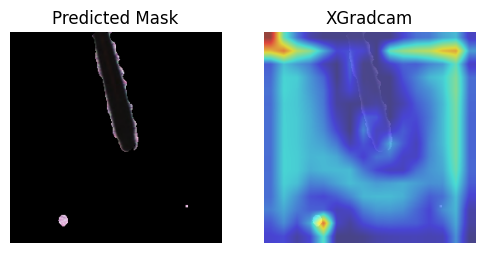

ResNet Prediction: Cancer (Acc: 0.50)


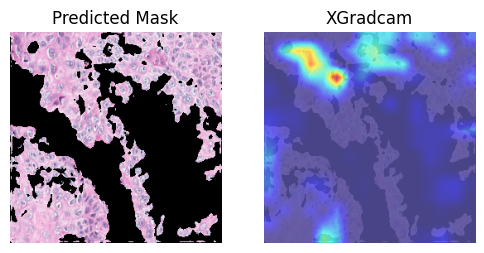

ResNet Prediction: Cancer (Acc: 0.63)


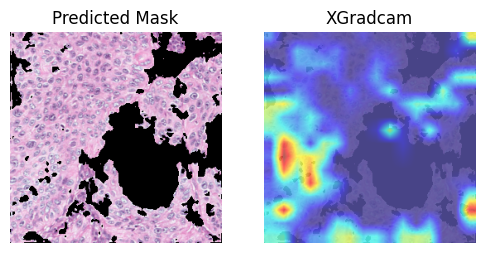

ResNet Prediction: Cancer (Acc: 0.54)


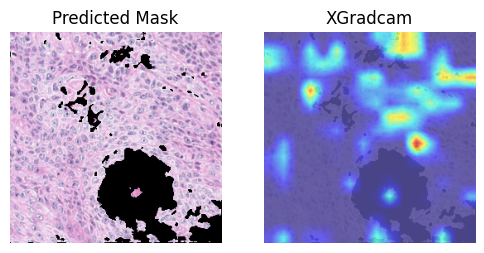

ResNet Prediction: No Cancer (Acc: 0.35)


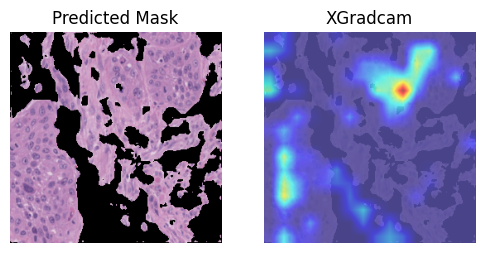

In [68]:
model.eval()
counter = 0

for ev_images, ev_masks in test_dataloader:
    with torch.no_grad():
        ev_images, ev_masks = ev_images.to(device), ev_masks.to(device)
        ev_outputs = model(ev_images)
        ev_binary_predictions = (ev_outputs > 0.5).float()
        new_image = ev_images[0].clone()
        binary_mask = ev_binary_predictions[0].expand_as(new_image) # To address RGB problems
        new_image[binary_mask == 0] = 0 # Assigning the pixels
        new_image_np = new_image.to("cpu").numpy().transpose(1, 2, 0)
        counter += 1

        plt.figure(figsize=(6, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(new_image_np)
        plt.title('Predicted Mask')
        plt.axis('off')

        model_resnet.eval()
        resnet_output = model_resnet(new_image.unsqueeze(0).to(device))
        resnet_output = resnet_output.squeeze()
        prediction = torch.sigmoid(resnet_output[1]).item()
        classification = "Cancer" if prediction > 0.5 else "No Cancer"
        print(f"ResNet Prediction: {classification} (Acc: {prediction:.2f})")

    new_image_4d = new_image.unsqueeze(0)
    
    plt.subplot(1, 2, 2)
    plt.imshow(generate_ResNet_CAM(model_resnet, new_image_4d, 0, [model_resnet.layer3[-1]], "xgradcam"))
    plt.title('XGradcam')
    plt.axis('off')
    
    plt.show()
    
    if counter == 5:  # Display only 5 images
            break


### Plotting Charts



In [ ]:
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

def to_cpu_and_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    return data

training_losses = [to_cpu_and_numpy(loss) for loss in training_losses]
val_losses = [to_cpu_and_numpy(loss) for loss in val_losses]
training_accuracies = [to_cpu_and_numpy(acc) for acc in training_accuracies]
val_accuracies = [to_cpu_and_numpy(acc) for acc in val_accuracies]

plt.plot(epochs_list, training_losses, label='Training Loss', color='blue')
plt.plot(epochs_list, val_losses, label='Validation Loss', color='orange')
plt.plot(epochs_list, training_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy', color='red')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()


### Predictions

In [ ]:
if show_images:
    counter = 0
    brightness = 0.5
    for images, masks in test_dataloader:
        with torch.no_grad():
            images, masks = images.to(device), masks.to(device)
            images_normalized = images

            outputs = model(images_normalized)
            probs = outputs
            #probs = F.softmax(outputs, dim=1)

            images_np = images_normalized.cpu().numpy()
            masks_np = masks.cpu().numpy()
            probs_np = probs.cpu().numpy()

            threshold = 0.5
            preds_np = (probs_np > threshold).astype(np.uint8)
            preds_np_squeezed = np.squeeze(preds_np, axis=1) 

            original_image = images_np[0].transpose((1, 2, 0))
            ground_truth_mask = masks_np[0, 0]
            predicted_mask = preds_np_squeezed[0]
            probability_map = probs_np[0, 0]

            overlay_gt = original_image.copy()
            overlay_gt = original_image * brightness # to make it a little darker
            overlay_gt[ground_truth_mask == 1] = [1, 1, 0]

            overlay_pred = original_image.copy()
            overlay_pred = original_image * brightness
            overlay_pred[predicted_mask == 1] = [0, 1, 1]

            overlay_diff = original_image.copy()
            overlay_diff = original_image * brightness 
            overlay_diff[(ground_truth_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]  #correct predictions
            overlay_diff[(ground_truth_mask == 1) & (predicted_mask == 0)] = [1, 0, 0]  #missed predictions
            overlay_diff[(ground_truth_mask == 0) & (predicted_mask == 1)] = [0, 0, 1]  #false positives

            plt.figure(figsize=(28, 4))

            plt.subplot(1, 7, 1)
            plt.imshow(original_image)
            plt.axis("off")
            plt.title("Original Image")

            plt.subplot(1, 7, 2)
            plt.imshow(ground_truth_mask, cmap='gray')
            plt.axis("off")
            plt.title("Ground Truth Mask")

            plt.subplot(1, 7, 3)
            plt.imshow(probability_map, cmap='plasma')
            plt.axis("off")
            plt.title("Probability Map")

            plt.subplot(1, 7, 4)
            plt.imshow(predicted_mask, cmap='gray')
            plt.axis("off")
            plt.title("Predicted Mask")

            plt.subplot(1, 7, 5)
            plt.imshow(overlay_gt)
            plt.axis("off")
            plt.title("Overlay Ground Truth")

            plt.subplot(1, 7, 6)
            plt.imshow(overlay_pred)
            plt.axis("off")
            plt.title("Overlay Pred")

            green_patch = mpatches.Patch(color='green', label='True Positive')
            red_patch = mpatches.Patch(color='red', label='False Negative')
            blue_patch = mpatches.Patch(color='blue', label='False Positive')
            plt.subplot(1, 7, 7)
            plt.imshow(overlay_diff)
            plt.title("Overlay Diff")
            plt.axis("off")
            plt.legend(handles=[green_patch, red_patch, blue_patch], loc='upper right')

            plt.show()

        #showing gradcams
        resnet_img = generate_ResNet_CAM(model_resnet, images, 0, [model_resnet.layer3[-1]], "xgradcam")
        plt.subplot(1,2,1)
        plt.imshow(resnet_img)
        plt.title("ResNet GradCam")
        plt.axis("off")

        plt.subplot(1,2,2)
        #gradcam heatmap
        heatmap = generate_heatmap_with_tensor(images[0].half())
        img = images[0].cpu().detach().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min()) #normalizing
        img = np.uint8(255 * img)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(heatmap, 0.6, img, 1 - 0.6, 0)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title('GradCAM with Overlay')
        plt.axis('off')
        
        plt.show()

        counter += 1
        if counter == 10:
            break